**Dataset Modeling - XGBoost**

In [ ]:
import rpy2
import pandas as pd 
import numpy as np
import os 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

#!pip install sklearn
df = pd.read_csv('ExportedSubsetData.csv')
#Print data frame
df
#Dataset Info Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 42.0+ MB


**1. Data Cleaning**

In [ ]:
# 1.1 - Removing Variables not needed for Calssification
newData = df.drop(['nameOrig', 'nameDest'], axis=1)
newData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   oldbalanceOrg   500000 non-null  float64
 4   newbalanceOrig  500000 non-null  float64
 5   oldbalanceDest  500000 non-null  float64
 6   newbalanceDest  500000 non-null  float64
 7   isFraud         500000 non-null  int64  
 8   isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 34.3+ MB


In [ ]:
# 1.2 - Retaining only CASH-OUT and TRANSFER transactions
newData = newData.loc[newData['type'].isin(['CASH_OUT', 'TRANSFER']),:]
print('The new data now has', len(newData), ' transations.')

The new data now has 217642  transations.


In [ ]:
# 1.3 - Converting categorical varaible to numeric representation
# Encoding categorical "type" variable to convert transation type to binary variables
newData = pd.get_dummies(newData, columns=['type'], prefix=['type'])
newData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217642 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            217642 non-null  int64  
 1   amount          217642 non-null  float64
 2   oldbalanceOrg   217642 non-null  float64
 3   newbalanceOrig  217642 non-null  float64
 4   oldbalanceDest  217642 non-null  float64
 5   newbalanceDest  217642 non-null  float64
 6   isFraud         217642 non-null  int64  
 7   isFlaggedFraud  217642 non-null  int64  
 8   type_CASH_OUT   217642 non-null  uint8  
 9   type_TRANSFER   217642 non-null  uint8  
dtypes: float64(5), int64(3), uint8(2)
memory usage: 15.4 MB


In [ ]:
# Print first 5 rows
newData.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
0,182,129804.96,0.00,0.0,4225880.68,4355685.64,0,0,1,0
4,252,61214.57,0.00,0.0,364102.11,425316.68,0,0,1,0
5,18,125379.52,0.00,0.0,883177.46,1120071.12,0,0,1,0
6,331,30449.41,0.00,0.0,456924.04,487373.45,0,0,1,0
7,277,157649.53,7660.25,0.0,491363.14,649012.67,0,0,1,0


In [ ]:
# To check min value of a feature. For Example:
newData['step'].min()

1

In [ ]:
# To check max value of a feature. For Example:
newData['step'].max()

742

**2. Data Normalization**

In [ ]:
# 2.1 (a) - Standardizing the Data or Scale Data using MinMaxScaler to convert the value between the min and max
# https://www.youtube.com/watch?v=sFVxFCYiIQI (15:00)
from sklearn.preprocessing import MinMaxScaler
scale_vars = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud' ]
scaler = MinMaxScaler()
newData[scale_vars] = scaler.fit_transform(newData[scale_vars])
newData.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
0,0.244265,0.002246,0.000000,0.0,0.012890,0.013281,0.0,0,1,0
4,0.338731,0.001059,0.000000,0.0,0.001111,0.001297,0.0,0,1,0
5,0.022942,0.002170,0.000000,0.0,0.002694,0.003415,0.0,0,1,0
6,0.445344,0.000527,0.000000,0.0,0.001394,0.001486,0.0,0,1,0
7,0.372470,0.002728,0.000175,0.0,0.001499,0.001979,0.0,0,1,0


In [ ]:
# 2.1 (b) - Data Normalization using the Min-Max Method 
normalized_df = newData.copy()

for column in normalized_df.columns:
  normalized_df[column] = (normalized_df[column] - normalized_df[column].min())/(normalized_df[column].max() - normalized_df[column].min())
normalized_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
0,0.244265,0.002246,0.000000,0.0,0.012890,0.013281,0.0,0.0,1.0,0.0
4,0.338731,0.001059,0.000000,0.0,0.001111,0.001297,0.0,0.0,1.0,0.0
5,0.022942,0.002170,0.000000,0.0,0.002694,0.003415,0.0,0.0,1.0,0.0
6,0.445344,0.000527,0.000000,0.0,0.001394,0.001486,0.0,0.0,1.0,0.0
7,0.372470,0.002728,0.000175,0.0,0.001499,0.001979,0.0,0.0,1.0,0.0


In [ ]:
# 2.1 (c) - Standardizing the Data: converting all columns to have the same range
# Normalization of dataset
std_scaler = StandardScaler()
data_scaled = pd.DataFrame(std_scaler.fit_transform(newData.loc[:,~newData.columns.isin(['isFraud'])]))
data_scaled.columns = newData.columns[:-1]
data_scaled['isFraud'] = newData['isFraud']

In [ ]:
# To validate min value of a feature has been converted. For Example:
newData['step'].min()

0.0

In [ ]:
# To validate max value of a feature has been converted. For Example:
newData['step'].max()

0.9999999999999999

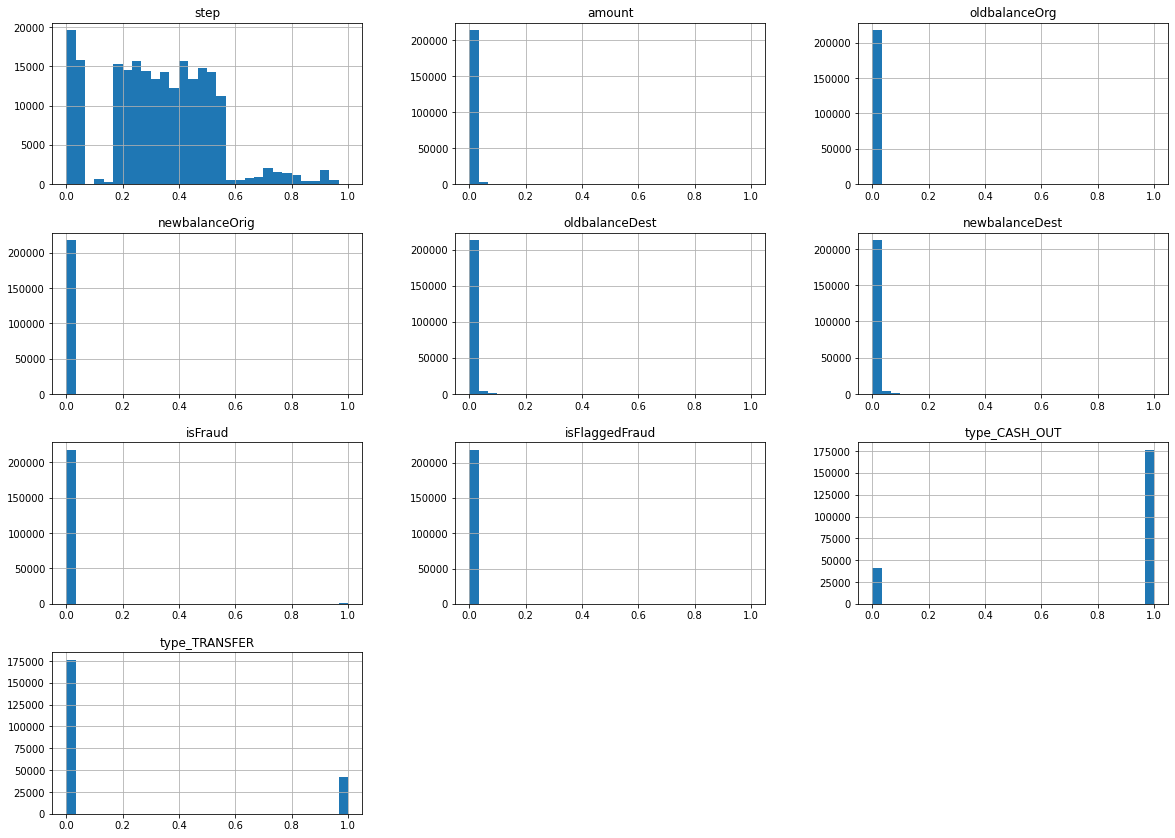

In [ ]:
# 2.2 - Visualize distributions
newData.hist(bins=30, figsize=(20,30), layout=(8,3));

In [ ]:
# 2.3 - Transformation of Independent Variables with visually non-normal distributions 
normalized_df[['step', 
         'amount',
         'oldbalanceOrg',
         'newbalanceOrig',
         'oldbalanceDest',
         'newbalanceDest',
         'isFraud']] = normalized_df[['step', 
         'amount',
         'oldbalanceOrg',
         'newbalanceOrig',
         'oldbalanceDest',
         'newbalanceDest',
         'isFraud']].applymap(lambda x: np.log(1+x))

normalized_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
count,217642.000000,217642.000000,217642.000000,217642.000000,217642.000000,217642.000000,217642.000000,217642.000000,217642.000000,217642.000000
mean,0.271587,0.005344,0.001066,0.000361,0.005102,0.006127,0.002026,0.000014,0.808984,0.191016
std,0.143868,0.013079,0.004850,0.002881,0.011536,0.012647,0.037415,0.003713,0.393102,0.393102
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.188823,0.001435,0.000000,0.000000,0.000394,0.001001,0.000000,0.000000,1.000000,0.000000
50%,0.276486,0.002958,0.000006,0.000000,0.001705,0.002525,0.000000,0.000000,1.000000,0.000000
75%,0.370213,0.005287,0.000704,0.000000,0.005296,0.006471,0.000000,0.000000,1.000000,0.000000
max,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,1.000000,1.000000,1.000000


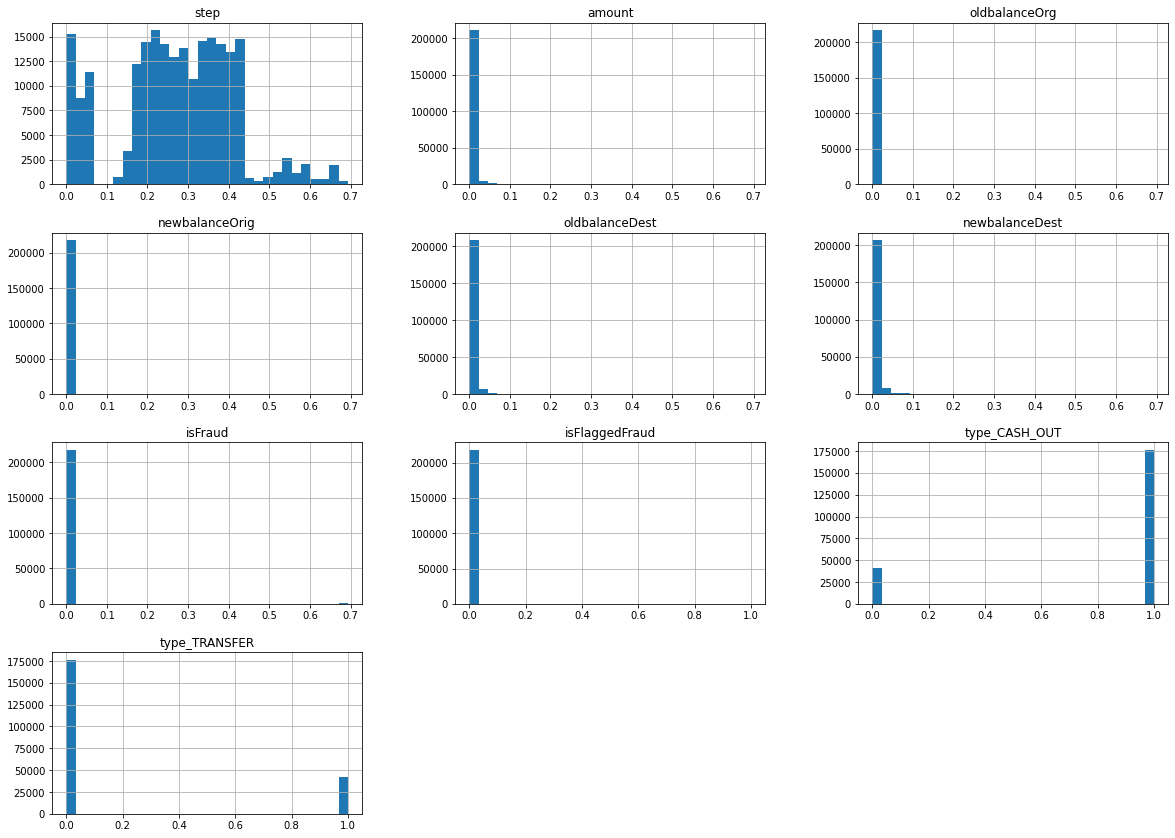

In [ ]:
# Visualize distributions
normalized_df.hist(bins=30, figsize=(20,30), layout=(8,3));

**3. Creation of Train and Test Dataset**

In [ ]:
# https://www.section.io/engineering-education/machine-learning-with-xgboost-and-scikit-learn/
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
feature_cols = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_CASH_OUT','type_TRANSFER']
X = newData[feature_cols] # Features
y = newData.isFraud # Target variable
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 3.1 - Version 1: Stratified K-fold Cross-Validation
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
# generate 2 class dataset
X, y = make_classification(n_samples=217642, n_classes=2, weights=[0.99, 0.01], flip_y=0, random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X, y):
	# select rows
	X_train, X_test = X[train_ix], X[test_ix]
	y_train, y_test = y[train_ix], y[test_ix]
	# summarize train and test composition
	train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
	test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
	print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
 
 # Preserve the class distribution in the train and test sets for each evaluation of a given model.

>Train: 0=118800, 1=1200, Test: 0=29700, 1=300
>Train: 0=118800, 1=1200, Test: 0=29700, 1=300
>Train: 0=118800, 1=1200, Test: 0=29700, 1=300
>Train: 0=118800, 1=1200, Test: 0=29700, 1=300
>Train: 0=118800, 1=1200, Test: 0=29700, 1=300


In [ ]:
# 3.2 - Version 2: Train/Test Split (30% Test Dataset)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# generate 2 class dataset
X, y = make_classification(n_samples=217642, n_classes=2, weights=[0.99, 0.01], flip_y=0, random_state=1)
# split into train/test sets with same class ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=150825, 1=1524, Test: 0=64640, 1=653


In [ ]:
# 3.3 - SMOT
# https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

sm = SMOTE(random_state=25, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
# 3.4 - Check class imbalance in Train and Test Datasets
#Class Imbalance - Percentage Frequency
dFraud = pd.DataFrame(y_train, columns= ['isFraud'])
# Percentage calculation
(dFraud['isFraud'].value_counts()/dFraud['isFraud'].count())*100

0    50.0
1    50.0
Name: isFraud, dtype: float64

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dTree_clf = DecisionTreeClassifier()
dTree_clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
y_pred2 = dTree_clf.predict(X_test)
y_pred2
from sklearn.metrics import accuracy_score
print("Accuracy of Model::",accuracy_score(y_test,y_pred2))

Accuracy of Model:: 0.9945782855742575


**Build XGBoost Model for Classification**

In [ ]:
# 4.1 - Test Dataset
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.798358
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.801174
[2]	validation_0-aucpr:0.816835
[3]	validation_0-aucpr:0.835498
[4]	validation_0-aucpr:0.84244
[5]	validation_0-aucpr:0.867752
[6]	validation_0-aucpr:0.869878
[7]	validation_0-aucpr:0.870395
[8]	validation_0-aucpr:0.869546
[9]	validation_0-aucpr:0.894116
[10]	validation_0-aucpr:0.894622
[11]	validation_0-aucpr:0.901494
[12]	validation_0-aucpr:0.904114
[13]	validation_0-aucpr:0.904859
[14]	validation_0-aucpr:0.904543
[15]	validation_0-aucpr:0.905381
[16]	validation_0-aucpr:0.912472
[17]	validation_0-aucpr:0.916331
[18]	validation_0-aucpr:0.917037
[19]	validation_0-aucpr:0.916863
[20]	validation_0-aucpr:0.917127
[21]	validation_0-aucpr:0.916304
[22]	validation_0-aucpr:0.91638
[23]	validation_0-aucpr:0.917589
[24]	validation_0-aucpr:0.917748
[25]	validation_0-aucpr:0.918438
[26]	validation_0-aucpr:0.918958
[27]	validation_0-aucpr:0.918881
[28]	validation_0-aucp

XGBClassifier(seed=42)

In [ ]:
# 4.2 - Test Dataset: Import the metrics class
from sklearn import metrics
y_pred=clf_xgb.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[29335,   365],
       [   17,   283]])

Text(0.5, 257.44, 'Predicted label')

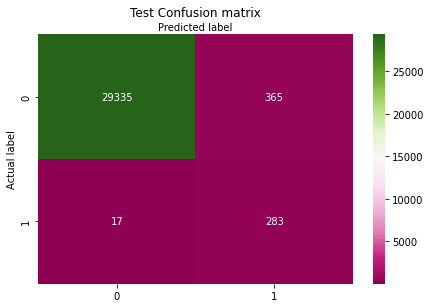

In [ ]:
# 4.3 - Test Dataset: Visualizing Confusion Matrix using Heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="PiYG" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Test Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
# 4.4 - Test Dataset: Confusion Matrix Evaluation Metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9872666666666666
Precision: 0.4367283950617284
Recall: 0.9433333333333334


In [ ]:
# Version 1:
# F1 Score - https://www.statology.org/f1-score-in-python/
# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
# Precision: Correct positive predictions relative to total positive predictions
# Recall: Correct positive predictions relative to total actual positives

import numpy as np
from sklearn.metrics import f1_score

#define array of actual classes
actual = np.repeat([1, 0], repeats=[435, 43093])

#define array of predicted classes
pred = np.repeat([1, 0, 1, 0], repeats=[431, 4, 387, 42706])

#calculate F1 score
f1_score(actual, pred)

0.6879489225857941

In [ ]:
# 4.5 - Train Dataset: Import the metrics class
from sklearn import metrics
y_pred=clf_xgb.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
cnf_matrix

array([[172207,    165],
       [    87,   1655]])

Text(0.5, 257.44, 'Predicted label')

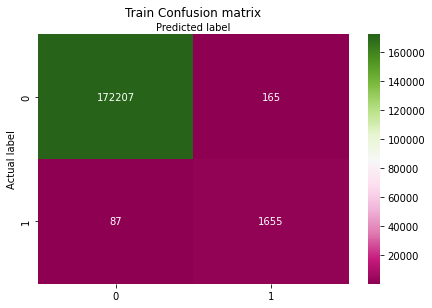

In [ ]:
# 4.6 - Train Dataset: Visualizing Confusion Matrix using Heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="PiYG" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Train Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
# 4.7 - Train Dataset: Confusion Matrix Evaluation Metrics
print("Accuracy:",metrics.accuracy_score(y_train, y_pred))
print("Precision:",metrics.precision_score(y_train, y_pred))
print("Recall:",metrics.recall_score(y_train, y_pred))

Accuracy: 0.9985526723870568
Precision: 0.9093406593406593
Recall: 0.9500574052812859


In [ ]:
# Version 2:
# F1 Score - https://www.statology.org/f1-score-in-python/
# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
# Precision: Correct positive predictions relative to total positive predictions
# Recall: Correct positive predictions relative to total actual positives

import numpy as np
from sklearn.metrics import f1_score

#define array of actual classes
actual = np.repeat([1, 0], repeats=[172372, 172372])

#define array of predicted classes
pred = np.repeat([1, 0, 1, 0], repeats=[172121, 251, 1560, 170812])

#calculate F1 score
f1_score(actual, pred)

0.9947666975867858